In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class BernoulliBandit:
    '''伯努利多臂老虎机,输入K表示拉杆个数'''
    def __init__(self,K):
        #K个不同的伯努利分布,
        self.prob = np.random.uniform(0,1,size=K)
        #最佳拉杆序号
        self.best_idx = np.argmax(self.prob)
        #最佳拉杆概率
        self.best_prob = self.prob[self.best_idx]
        #拉杆数量
        self.K = K

    #obtain sample 采样
    def step(self,k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖
        prob = self.prob[k]
        return np.random.choice([1,0],p=[prob,1-prob])
    
np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %(bandit_10_arm.best_idx, bandit_10_arm.best_prob))


随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [4]:
class Solver:
    '''
    多臂老虎机算法基础框架:
        1. RM算法增量式解决期望
        2. 最大化积累奖励优化
        3. 不包含具体的策略选择
    '''
    def __init__(self,bandit):
        self.bandit = bandit
        #每一根拉杆的尝试次数
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0
        self.actions = [] #record actions of each steps
        self.regrets = [] 

    def update_regets(self,k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.prob[k]   #误差总和, 目标是最小化误差总和
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆, 由每一个具体的策略实现
        return NotImplementedError
    
    def run(self,num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1 #k号拉杆的尝试次数
            self.update_regets(k)
            self.actions.append(k) #动作就是拉下k号拉杆

在多臂老虎机问题中，设计策略时就需要平衡探索和利用的次数，   
使得累积奖励最大化。一个比较常用的思路是在开始时做比较多的探索，   
在对每根拉杆都有比较准确的估计后，再进行利用。   

In [5]:

class EpsilonGreedy(Solver):
    """ epsilon贪心算法,继承Solver类 """
    def __init__(self, bandit,epsilon=0.01,init_prob=1.0):
        super(EpsilonGreedy,self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有杠杆的奖励期望
        self.estimates = np.array([init_prob]*self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            #随机选择一根拉杆
            k = np.random.randint(0,self.bandit.K)
        else:
            #选择当前奖励期望最大的拉杆
            k = np.argmax(self.estimates)
            #计算奖励r
            r = self.bandit.step(k)
            #更新拉杆k的期望
            self.estimates[k] += (1.0 / self.counts[k]) * (r - self.estimates[k])
        return k
    

In [6]:
    
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


epsilon-贪婪算法的累积懊悔为： 26.37133447562636


C:\Users\10546\AppData\Local\Temp\ipykernel_24344\1464030511.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  self.estimates[k] += (1.0 / self.counts[k]) * (r - self.estimates[k])
C:\Users\10546\AppData\Local\Temp\ipykernel_24344\1464030511.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  self.estimates[k] += (1.0 / self.counts[k]) * (r - self.estimates[k])


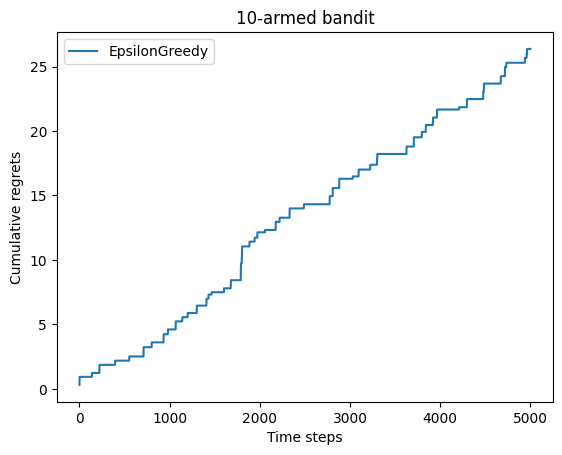

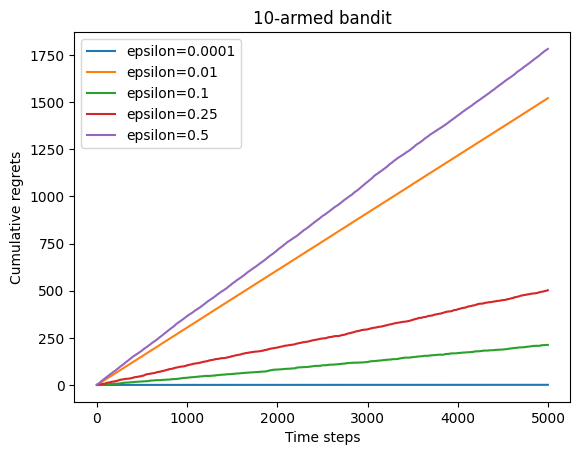

In [7]:

np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

np.random.seed(0)
epsilons = [1e-4,0.01,0.1,0.25,0.5]
epsilon_greedy_solver_list = [EpsilonGreedy(bandit_10_arm,epsilon=e) for e in epsilons]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for sovler in epsilon_greedy_solver_list:
    sovler.run(5000)

plot_results(epsilon_greedy_solver_list,epsilon_greedy_solver_names)


epsilon值衰减的贪婪算法的累积懊悔为: 10.114334931260183


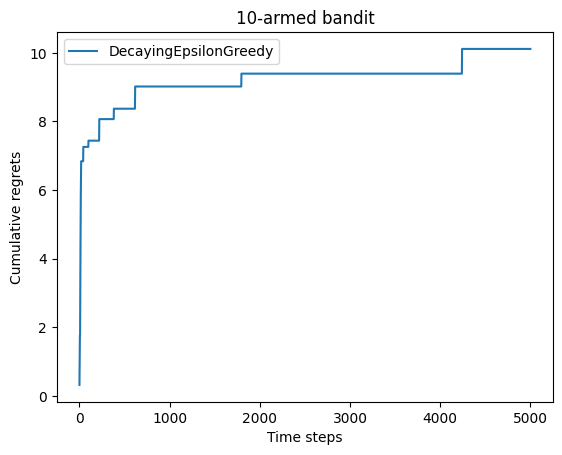

In [8]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪心算法,继承Solver类 """
    #这种算法表明先探索后利用的思想的有效性.
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为:', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])


上置信界算法的累积懊悔为： 4.360254345326592


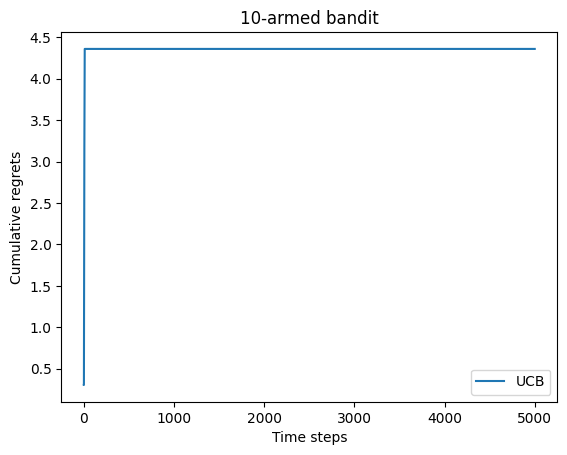

In [9]:
#上界置信算法
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self,bandit,colf,init_prob=1.0):
        super(UCB,self).__init__(bandit)
        self.colf = colf
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        self.total_count += 1
        #不确定性u
        u = np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))
        #ucb算法
        ucb = self.estimates + self.colf * u
        k = np.argmax(ucb)
        #计算奖励
        r = self.bandit.step(k)
        #记录预测
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

np.random.seed(1)
coef = 0.5  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

MAB 中还有一种经典算法——***汤普森采样（Thompson sampling）***，先假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来进行选择。但是由于计算所有拉杆的期望奖励的代价比较高，汤普森采样算法使用采样的方式，即根据当前每个动作$a$的奖励概率分布进行一轮采样，得到一组各根拉杆的奖励样本，再选择样本中奖励最大的动作。可以看出，汤普森采样是一种计算所有拉杆的最高奖励概率的蒙特卡洛采样方法。

汤普森采样算法的累积懊悔为： 26.42071590568392


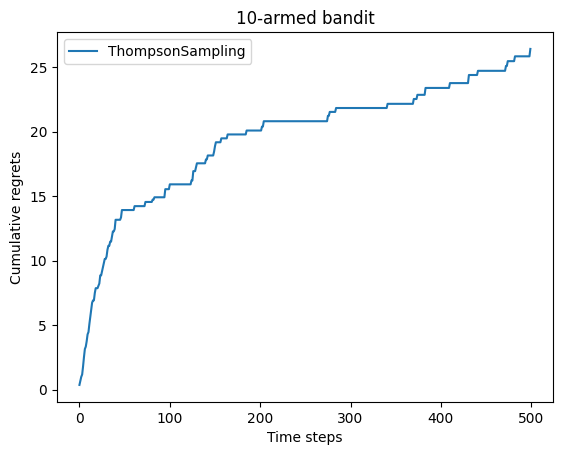

In [ ]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self,bandit):
        super(ThompsonSampling,self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a,self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)

        self._a[k] += r
        self._b[k] += 1-r
        return k

np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])


多臂老虎机问题与强化学习的一大区别在于其与环境的交互并不会改变环境，即多臂老虎机的每次交互的结果和以往的动作无关，所以可看作***无状态的强化学习（stateless reinforcement learning）***。第 3 章将开始在有状态的环境下讨论强化学习，即马尔可夫决策过程。